In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [2]:
prefix='client-bench'

In [3]:
res_dir = os.listdir(f'../{prefix}')[0]
res_dir = f"{prefix}/{res_dir}"

In [4]:
def import_pidstat(res_dir):
    pidstat = pd.read_csv(f"../{res_dir}/summary/server/cpu-pidstat.csv")
    pidstat = pidstat[pidstat.used >= 0]
    tmp = pidstat.groupby(['cpu', 'client', 'core', 'timestamp', 'run']).sum(numeric_only=True).reset_index() 
    tmp = tmp.groupby(['cpu', 'client', 'core', 'run']).median(numeric_only=True).reset_index()
    percore = tmp.groupby(['cpu', 'client', 'core']).median(numeric_only=True).reset_index()
    global_cpu = tmp.groupby(['cpu', 'client']).median().reset_index()
    return global_cpu, percore

def import_cpu(res_dir):
    cpu = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu = cpu[cpu.core != -1]
    tmp = cpu.groupby(['cpu', 'client', 'core', 'run']).median().reset_index()
    tmp = cpu.groupby(['cpu', 'client', 'core']).median().reset_index()
    tmp['used'] = 100 - tmp['idle']
    global_cpu = tmp.groupby(['cpu', 'client']).median().reset_index()
    return global_cpu, tmp

def import_latency(res_dir):
    latency = pd.read_csv(f"../{res_dir}/summary/clients/sockperf-1.csv")
    tails = ['99th', '99.9th', '99.99th', '99.999th',]
    cols = ['min', 'median', 'max'] + tails
    latency = latency.groupby(['cpu', 'client', 'run']).median().reset_index()
    latency = latency.groupby(['cpu', 'client']).median().reset_index()
    latency[cols] /= 1000
    return latency

def import_throughput(res_dir):
    net = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    net = net[net.iface == 'wg']
    net = net.groupby(['cpu', 'client', 'run']).median(numeric_only=True).reset_index()
    net = net.groupby(['cpu', 'client',]).median(numeric_only=True).reset_index()
    net['rxkB/s'] = net['rxkB/s'] * 8 / 1e6
    net['txkB/s'] = net['txkB/s'] * 8 / 1e6
    return net

def plot_all(res_dirs, importer, kind='bar', y='used', 
             variants=[0,1], variant_names=['VANILLA', 'CRYPTONCE'], correct=[], 
             ylabel='CPU Usage (in \%)', ylim=None, figsize=(4, 3), ncols=1,
             space=.1, annotate='improvement', annotate_baseline='VANILLA', annotate_variant='CRYPTONCE', 
             fontsize=8, savefig=None, columnspacing=1):
#     vanilla = importer(res_dirs[0][0])
#     cryptonce = importer(res_dirs[1][0])
    baseline = importer(res_dirs[variants[0]][0])
    
    dfs = [importer(res_dirs[i][0]) for i in variants]

    for df_idx, key, val in correct:
        dfs[df_idx].loc[key, y] = val
    
    df = pd.DataFrame()
    df['client'] = dfs[0]['client']
    for df_, name in zip(dfs, variant_names):
        df[name] = df_[y]
    
    df['diff'] = df[annotate_baseline] - df[annotate_variant]
    df['improvement'] = df['diff'] * 100 / df[annotate_baseline]

    with plt.style.context(['science', 'ieee']):
        if kind == 'bar':
            ax = df.plot.bar(x='client', y=variant_names, color=['black', 'red', 'blue', 'green'],
                   grid=True, ylabel=ylabel, ylim=ylim, figsize=figsize, xlabel='Clients')
            plt.xticks(rotation=0)
            
            if annotate is not None:
                for k, i in enumerate(df.index):
                    suffix = "\%" if annotate == "improvement" else ""
                    max_height = df.loc[i, annotate_baseline]  # Position at the higher bar
                    ax.text(k, max_height + space, f'{df.loc[i, annotate]:.2f}{suffix}', 
                            ha='center', fontsize=fontsize)
            
        elif kind == 'line':
            ax = baseline.plot(
                x='client', y=y, grid=True, color='black', marker='x',
                label=variant_names[0], xlabel='Clients', ylabel=ylabel,
            )
            for df_, name in zip(dfs[1:], variant_names[1:]):
                ax = df_.plot(ax=ax, marker='o', figsize=figsize,
                    x='client', y=y, grid=True, color='red',
                    label=name, xlabel='Clients', ylabel=ylabel, ylim=ylim
                )
        plt.legend(loc='upper left', ncol=ncols, columnspacing=columnspacing)
        if savefig is not None:
            plt.savefig(savefig, dpi=400)
        plt.show()
    return df

In [5]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, suffix = test_config.split('--')
        crypted = suffix.split('-')[0]
        threaded = "-".join(suffix.split('-')[1:])
#         threaded = len(suffix.split('-')[1:]) == 2
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, threaded

In [7]:
# res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
#             for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [21]:
res_dirs = os.listdir(f'../{prefix}')
variants = []

for res_dir in res_dirs:
    with open(f"../{prefix}/{res_dir}/EXPERIMENT_DATA/CURRENT_EXP") as f:
        variant = f.read().strip().split('-')[1].upper()
        variants.append(variant)

In [22]:
variants

['CRYPTONCE', 'VANILLA']

In [58]:

dfs = {}

for res_dir, variant in zip(res_dirs, variants):
    scp = pd.read_csv(f'../{prefix}/{res_dir}/summary/scp.csv')
    scp['variant'] = variant
    dfs[variant] = scp.set_index(['filesize', 'direction'])

# Cryptonce - VANILLA

In [45]:
diff = dfs['CRYPTONCE']['duration'] - dfs['VANILLA']['duration']

In [49]:
dfs['VANILLA']['duration']

filesize  direction
1G        upload       3.035964
2G        upload       5.709808
5G        upload       6.360364
1G        download     2.942367
2G        download     5.463141
5G        download     5.525271
Name: duration, dtype: float64

In [50]:
impr = diff * 100 / dfs['VANILLA']['duration']

In [54]:
df = pd.DataFrame(impr).reset_index()

In [55]:
df

,filesize,direction,duration
0,1G,upload,-0.343341
1,2G,upload,0.872648
2,5G,upload,-10.511183
3,1G,download,0.397208
4,2G,download,1.872296
5,5G,download,-0.445711


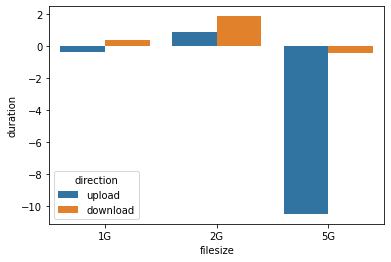

In [57]:
sns.barplot(df, x='filesize', y='duration', hue='direction')
plt.show()

In [64]:

dfs = {}

for res_dir, variant in zip(res_dirs, variants):
    df = pd.read_csv(f'../{prefix}/{res_dir}/summary/streaming.csv')
    df['variant'] = variant
    dfs[variant] = df

In [66]:
dfs['CRYPTONCE']

,run,resolution,bitrate,framerate,format,variant
0,1,480p,854.8kbits/s,1471,mpeg,CRYPTONCE
1,1,720p,1329.4kbits/s,929,mpeg,CRYPTONCE
2,1,1080p,2233.9kbits/s,504,mpeg,CRYPTONCE


In [67]:
dfs['VANILLA']

,run,resolution,bitrate,framerate,format,variant
0,1,480p,854.8kbits/s,1464,mpeg,VANILLA
1,1,720p,1329.4kbits/s,929,mpeg,VANILLA
2,1,1080p,2233.9kbits/s,504,mpeg,VANILLA
